# Chocolate Sales Forecasting — 2025 Forecast Generation

This notebook generates the final monthly forecasts for the year 2025 using the saved models from the modeling stage.  
It includes:
- Loading the trained models (revenue and boxes) and the required feature list
- Building recursive month-by-month predictions for 2025 (using lag-based inputs)
- Producing forecast tables and summary aggregations (per country and total)
- Running basic sanity checks and exporting results for reporting or dashboards

**Output:** `forecast_2025.csv` containing predicted monthly revenue and boxes shipped for 2025.

In [19]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Load
MODELS_DIR = Path("../models")
DATA_DIR = Path("../data")
OUT_DIR = Path("../outputs")

pipe_hgb_rev = joblib.load(MODELS_DIR / "hgb_revenue.joblib")
pipe_hgb_box = joblib.load(MODELS_DIR / "hgb_boxes.joblib")

with open(MODELS_DIR / "features.json") as f:
    FEATURES = json.load(f)

monthly = pd.read_csv(DATA_DIR / "monthly_data.csv", parse_dates=["ds"])
monthly.head()

,country,total_revenue,total_boxes,ds,rev_lag_1,box_lag_1,rev_lag_2,box_lag_2,month_num
0,Australia,165431.0,4309,2022-03-01,126406.0,2635.0,187383.0,6449.0,3
1,Australia,120561.0,4470,2022-04-01,165431.0,4309.0,126406.0,2635.0,4
2,Australia,124264.0,4218,2022-05-01,120561.0,4470.0,165431.0,4309.0,5
3,Australia,145719.0,3955,2022-06-01,124264.0,4218.0,120561.0,4470.0,6
4,Australia,131082.0,3443,2022-07-01,145719.0,3955.0,124264.0,4218.0,7


In [20]:
# Forecast 2025 (recursive)

future_months = pd.date_range("2025-01-01", "2025-12-01", freq="MS")

def month_cyc(m):
    return np.sin(2*np.pi*m/12), np.cos(2*np.pi*m/12)

hist = monthly[["country", "ds", "total_revenue", "total_boxes"]].copy()

forecast_rows = []
for c in hist["country"].unique():
    h = hist[hist["country"] == c].copy().reset_index(drop=True)

    if len(h) < 2:
        print(f"Skipping {c}: not enough history for lag_2")
        continue

    for ds in future_months:
        rev_lag_1 = h.loc[h.index[-1], "total_revenue"]
        box_lag_1 = h.loc[h.index[-1], "total_boxes"]
        rev_lag_2 = h.loc[h.index[-2], "total_revenue"]
        box_lag_2 = h.loc[h.index[-2], "total_boxes"]

        mnum = ds.month
        msin, mcos = month_cyc(mnum)

        X_new = pd.DataFrame([{
            "country": c,
            "month_num": mnum,
            "rev_lag_1": rev_lag_1,
            "rev_lag_2": rev_lag_2,
            "box_lag_1": box_lag_1,
            "box_lag_2": box_lag_2,
            "month_sin": msin,
            "month_cos": mcos
        }])

        # enforce exact feature set/order used in training
        X_new = X_new[FEATURES]

        pred_rev = float(pipe_hgb_rev.predict(X_new)[0])
        pred_box = float(pipe_hgb_box.predict(X_new)[0])

        forecast_rows.append({
            "country": c,
            "ds": ds,
            "pred_total_revenue": pred_rev,
            "pred_total_boxes": pred_box
        })

        # append predictions for recursive lags
        h = pd.concat([h, pd.DataFrame([{
            "country": c,
            "ds": ds,
            "total_revenue": pred_rev,
            "total_boxes": pred_box
        }])], ignore_index=True)

forecast_2025 = pd.DataFrame(forecast_rows).sort_values(["country", "ds"]).reset_index(drop=True)
forecast_2025.head(24) # Peek forecast for Australia and Canada

,country,ds,pred_total_revenue,pred_total_boxes
0,Australia,2025-01-01,124540.493465,3652.385316
1,Australia,2025-02-01,142416.981873,3742.426267
2,Australia,2025-03-01,148544.429178,4208.819402
3,Australia,2025-04-01,121144.081512,3327.951756
4,Australia,2025-05-01,123483.832827,3528.497924
5,Australia,2025-06-01,152968.743550,4204.233398
6,Australia,2025-07-01,129724.907601,3515.857315
7,Australia,2025-08-01,143523.650540,3947.878353
8,Australia,2025-09-01,153945.860320,4307.993328
9,Australia,2025-10-01,142429.538224,3213.083218


In [21]:
# Sanity checks + clipping
print("Forecast shape:", forecast_2025.shape)
print(f"Any NaNs ? \n{forecast_2025.isna().sum()}")

# Clip negatives (forecasting models can sometimes produce small negatives)
forecast_2025["pred_total_revenue"] = forecast_2025["pred_total_revenue"].clip(lower=0)
forecast_2025["pred_total_boxes"]   = forecast_2025["pred_total_boxes"].clip(lower=0)

Forecast shape: (72, 4)
Any NaNs ? 
country               0
ds                    0
pred_total_revenue    0
pred_total_boxes      0
dtype: int64


In [22]:
# Save outputs

forecast_2025.to_csv(OUT_DIR / "forecast_2025.csv", index=False)

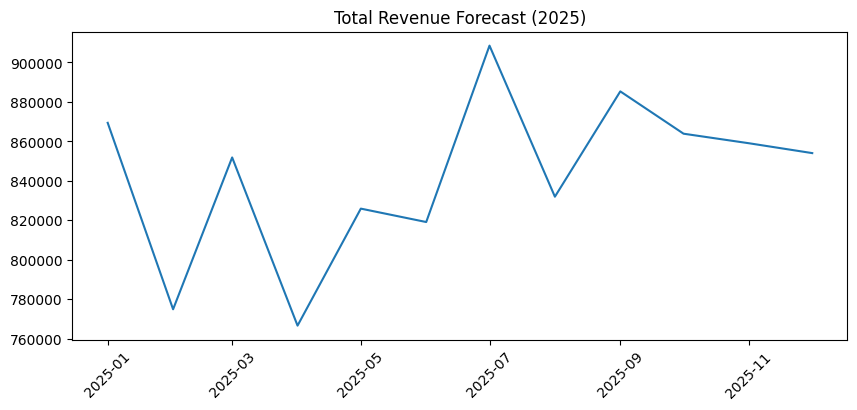

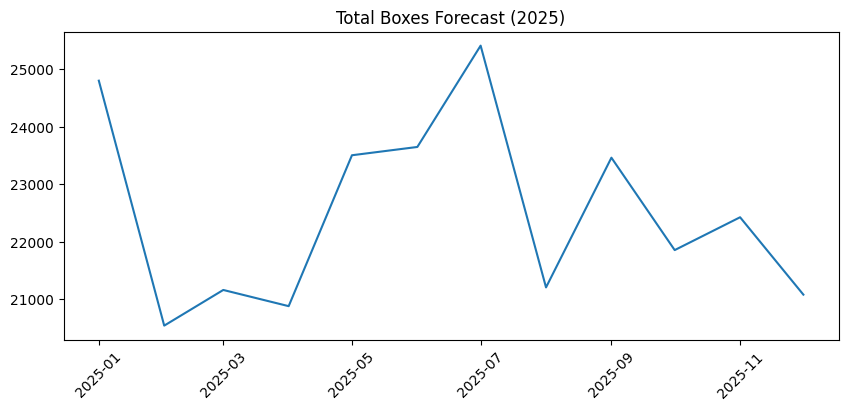

In [24]:
# Plots (total across all countries)

total_2025 = (forecast_2025.groupby("ds", as_index=False)
              .agg(pred_total_revenue=("pred_total_revenue", "sum"),
                   pred_total_boxes=("pred_total_boxes", "sum")))

plt.figure(figsize=(10,4))
plt.plot(total_2025["ds"], total_2025["pred_total_revenue"])
plt.title("Total Revenue Forecast (2025)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(total_2025["ds"], total_2025["pred_total_boxes"])
plt.title("Total Boxes Forecast (2025)")
plt.xticks(rotation=45)
plt.show()
